### Simulate some data points with a linear model and obtain $\ln R_{12}$
The model can be simply $y=mx+b$ with say fiducial $m=1$ and $b=0$, and then we can define two experiments that can measure $y$ with some error $\sigma_y(x)$. For the first simple test, we can assume that the data points are uncorrelated; this doesn't necessarily mean that the posterior for the model parameters $m,b$ will be uncorrelated. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from scipy.optimize import fmin_powell

def ymodel(x, m=0.5, b=0):
    return m*x + b

def yrealization(x, sigmay=1):
    # return a random realization for y(x)
    return np.random.normal(loc=ymodel(x), scale=sigmay)

In [3]:
xs1 = range(5)
xs2 = np.arange(-4, 1, 1)
xs = np.append(xs2, xs1)
os = np.ones(len(xs1))

In [15]:
# just for single plot
######################
sigma1 = 1
sigma2 = 1.5

d1 = np.array([yrealization(i, sigmay=sigma1) for i in xs1])
d2 = np.array([yrealization(i, sigmay=sigma2) for i in xs2])

def chisq1(params):
    m, b = params
    th1 = np.array([ymodel(x, m=m, b=b) for x in xs1])
    return np.sum(((d1-th1)/sigma1)**2.0)

def chisq2(params):
    m, b = params
    th2 = np.array([ymodel(x, m=m, b=b) for x in xs2])
    return np.sum(((d2-th2)/sigma2)**2.0)

def chisq12(params):
    m, b = params
    return chisq1(params) + chisq2(params)

r1 = fmin_powell(chisq1, x0=[0,1], disp=0);
r2 = fmin_powell(chisq2, x0=[0,1], disp=0);
r12 = fmin_powell(chisq12, x0=[0,1], disp=0);

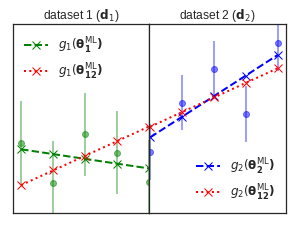

In [44]:
#atplotlib.style.use(matplotlib.style.available[0])
dalpha = 0.6
ealpha = 0.5

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4.25,3.25))
ax2.errorbar(xs1, d1, sigma1*os , fmt="bo", alpha=ealpha) #label=r"$\bf{d}_1$")
ax1.errorbar(xs2, d2, sigma2*os , fmt="go", alpha=ealpha) #label=r"$\bf{d}_1$")

ax1.xaxis.set_visible(False); ax1.yaxis.set_visible(False)
ax2.xaxis.set_visible(False); ax2.yaxis.set_visible(False)

cross_size = 8

ax2.plot(xs1, np.array([ymodel(x, m=r1[0], b=r1[1]) for x in xs1]), "b--x", label=r"$g_2(\bf{\theta}_2^{\rm ML})$", 
         linewidth=2, markersize=cross_size)
ax1.plot(xs2, np.array([ymodel(x, m=r2[0], b=r2[1]) for x in xs2]), "g--x", label=r"$g_1(\bf{\theta}_1^{\rm ML})$", 
         linewidth=2, markersize=cross_size)

ax2.plot(xs1, np.array([ymodel(x, m=r12[0], b=r12[1]) for x in xs1]), "rx", linestyle="dotted", 
        linewidth=2, markersize=cross_size, label=r"$g_2(\bf{\theta}_{12}^{\rm ML})$")
ax1.plot(xs2, np.array([ymodel(x, m=r12[0], b=r12[1]) for x in xs2]), "rx", linestyle="dotted", 
        linewidth=2, markersize=cross_size, label=r"$g_1(\bf{\theta}_{12}^{\rm ML})$")


ax1.set_title(r'dataset 1 (${\bf d}_1$)'); ax1.set_xlim(-4.25, 0.025); ax1.set_ylim(-2.5, 4.25); ax1.grid(linestyle="dotted")
ax2.set_title(r'dataset 2 (${\bf d}_2$)'); ax2.set_xlim(-0.025, 4.25); ax2.set_ylim(-2.5, 4.25); ax2.grid(linestyle="dotted")

ax1.legend(fontsize=12, loc=2)
ax2.legend(fontsize=12, loc=4)

f.tight_layout()
f.subplots_adjust(wspace=0)
#plt.savefig("gtheta_new2.pdf")

### Now compute the evidence ratio $R_{12}$ for the example datasets above

In [85]:
dbfsep1 = np.array([ymodel(x, m=r1[0], b=r1[1]) for x in xs1])
dbfsep2 = np.array([ymodel(x, m=r2[0], b=r2[1]) for x in xs2])

dbfcom1 = np.array([ymodel(x, m=r12[0], b=r12[1]) for x in xs1])
dbfcom2 = np.array([ymodel(x, m=r12[0], b=r12[1]) for x in xs2])

def lnlikesep(params):
        m, b = params
        th1 = np.array([ymodel(x, m=m, b=b) for x in xs1])
        th2 = np.array([ymodel(x, m=m, b=b) for x in xs2])

        return -0.5*(np.sum(((dbfsep1-th1)/sigma1)**2.) + np.sum((dbfsep2-th2)/sigma2)**2.)

def lnlikecom(params):
    m, b = params
    th1 = np.array([ymodel(x, m=m, b=b) for x in xs1])
    th2 = np.array([ymodel(x, m=m, b=b) for x in xs2])

    return -0.5*(np.sum(((dbfcom1-th1)/sigma1)**2.) + np.sum(((dbfcom2-th2)/sigma2)**2.))

from pymultinest.solve import solve

def Prior(cube):
    return -5+cube*10
    
def Loglike(cube):
    m, b = cube[0], cube[1]
    return -chisq12([m,b])

ressep = solve(LogLikelihood=lnlikesep, Prior=Prior, n_dims=2, resume=False,
           sampling_efficiency="model", n_live_points=400)
rescom = solve(LogLikelihood=lnlikecom, Prior=Prior, n_dims=2, resume=False,
           sampling_efficiency="model", n_live_points=400)

print (ressep['logZ']-rescom['logZ'], "+/-", ressep['logZerr']+rescom['logZerr'])

  analysing data from /tmp/tmp67n43p6rpymultinest/.txt
  analysing data from /tmp/tmppc3nk8iapymultinest/.txt
-0.8783811229893557 +/- 0.22020295976223708


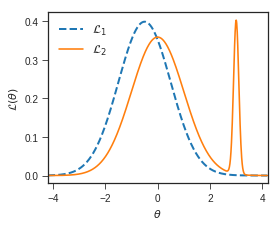

In [86]:
# the gaussian + peak plot
##########################
from scipy.stats import norm
x = np.arange(-4.2, 4.2, 0.01)
y1 = norm.pdf(x,-0.5, 1)
y2 = 0.9*norm.pdf(x, 0, 1) + 0.1*norm.pdf(x, 3, 0.1)

plt.figure(figsize=(4., 3.25))

plt.plot(x, y1, "--", linewidth=2.0, label=r'$\mathcal{L}_1$')
plt.plot(x, y2, linewidth=1.6, label=r'$\mathcal{L}_2$')

plt.xlim(-4.2,4.2); plt.xticks([-4, -2, 0, 2, 4]); plt.xlabel(r'$\theta$', fontsize=11)
plt.ylabel(r'$\mathcal{L}(\theta)$', fontsize=11)

plt.legend(fontsize=12)

plt.tight_layout()
#plt.savefig("nongaus2.pdf")